/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Evaluation Summary:

                    Accuracy Precision Recall F1 Score   AUC
Logistic Regression     0.97      1.00   0.94     0.97  0.99
Random Forest           0.95      0.97   0.94     0.95  0.99
SVM                     0.93      0.94   0.94     0.94  0.98
Decision Tree           0.95      0.97   0.94     0.95  0.95
KNN                     0.92      0.94   0.91     0.92  0.99
XGBoost                 0.93      0.94   0.94     0.94  0.99


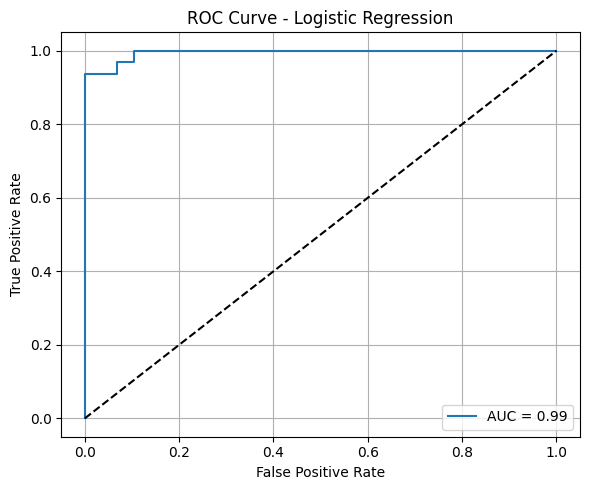

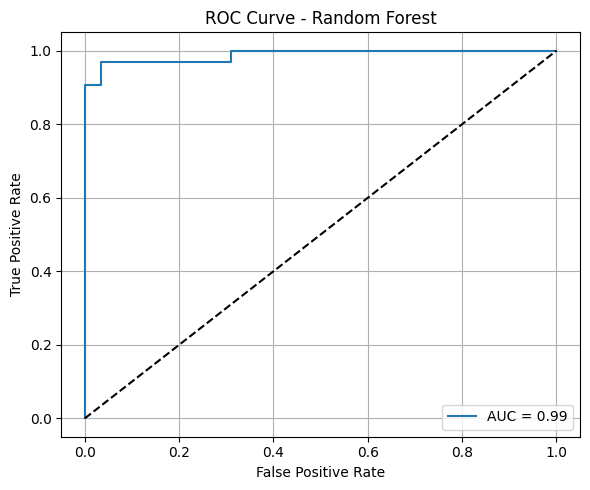

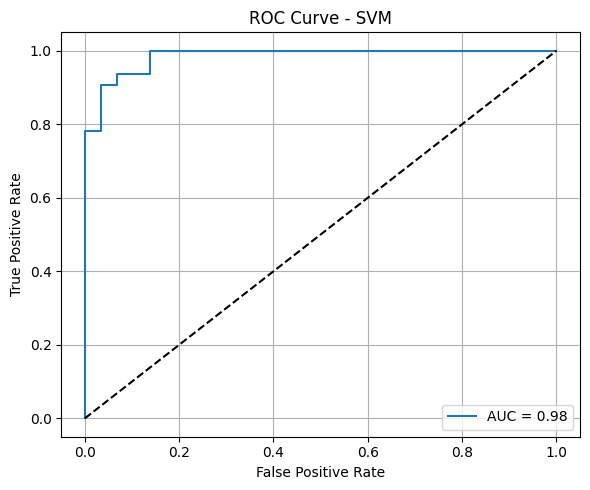

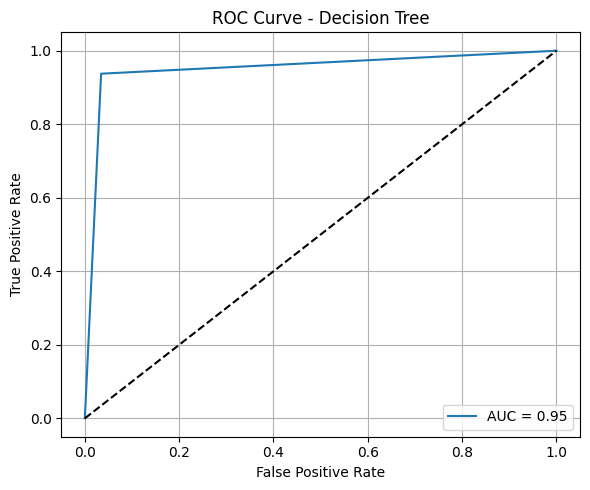

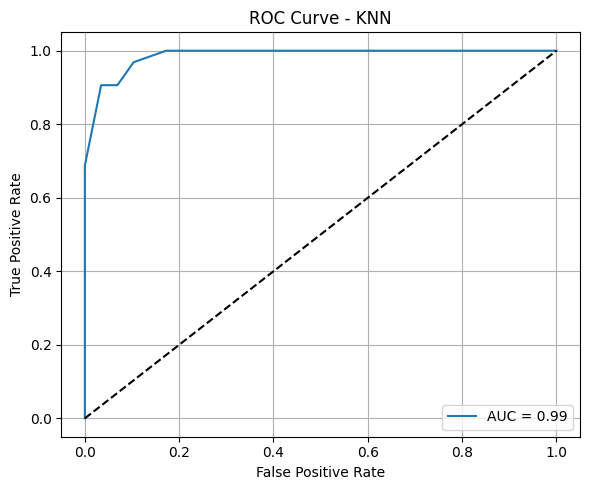

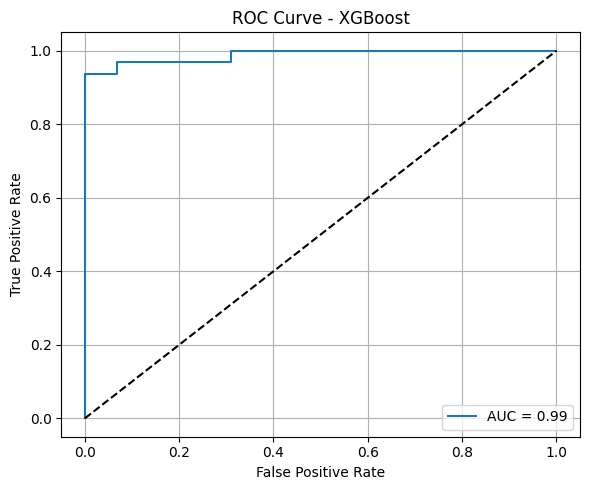

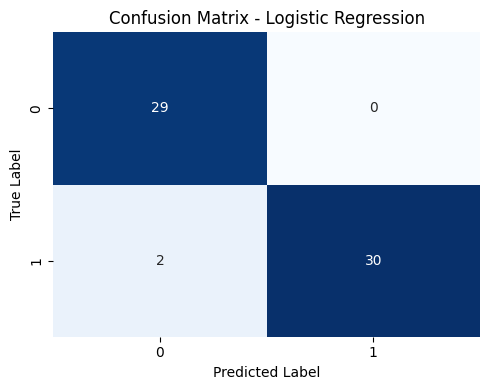

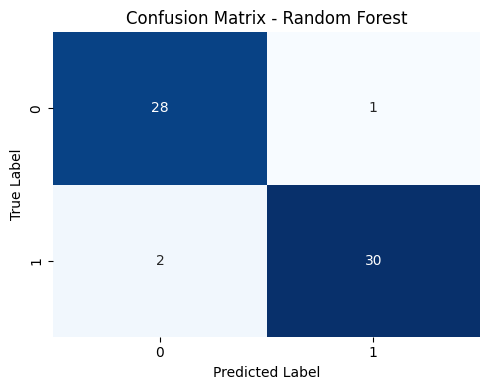

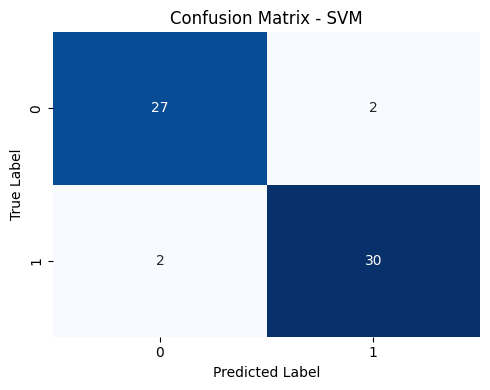

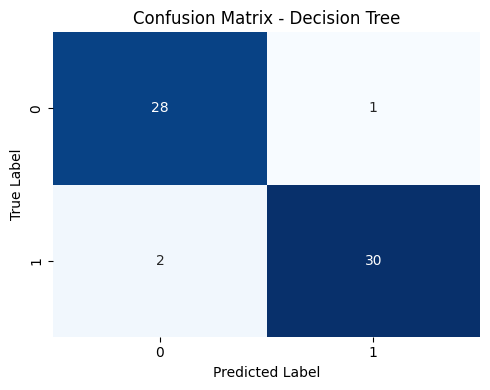

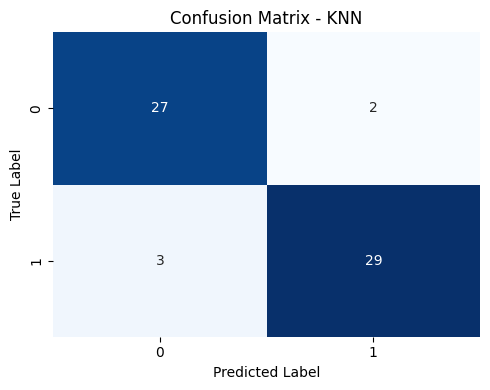

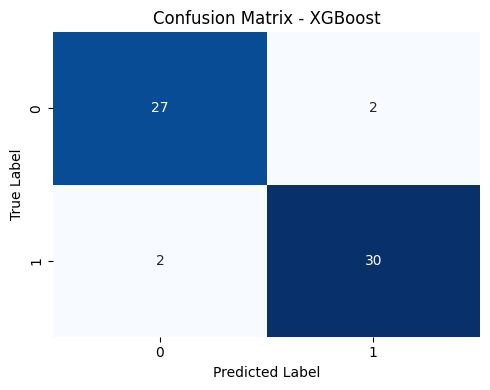

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("/content/car data.csv")

# Feature Engineering
df['Car_Age'] = 2025 - df['Year']
df.drop(['Car_Name', 'Year'], axis=1, inplace=True)

# Label Encoding
le = LabelEncoder()
for col in ['Fuel_Type', 'Selling_type', 'Transmission']:
    df[col] = le.fit_transform(df[col])

# Target Variable: High (>= median) = 1, Low (< median) = 0
median_price = df['Selling_Price'].median()
df['Price_Category'] = np.where(df['Selling_Price'] >= median_price, 1, 0)
df.drop('Selling_Price', axis=1, inplace=True)

# Feature and Target split
X = df.drop('Price_Category', axis=1)
y = df['Price_Category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classifiers
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

results = {}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc,
        "Confusion Matrix": cm,
        "ROC Curve": (fpr, tpr)
    }

# Summary Table
summary = pd.DataFrame({
    model: {
        "Accuracy": f"{metrics['Accuracy']:.2f}",
        "Precision": f"{metrics['Precision']:.2f}",
        "Recall": f"{metrics['Recall']:.2f}",
        "F1 Score": f"{metrics['F1 Score']:.2f}",
        "AUC": f"{metrics['AUC']:.2f}"
    }
    for model, metrics in results.items()
}).T

print("Model Evaluation Summary:\n")
print(summary)

# Plot ROC Curves Separately
for name, result in results.items():
    fpr, tpr = result["ROC Curve"]
    auc = result["AUC"]

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot Confusion Matrices Separately
for name, result in results.items():
    cm = result["Confusion Matrix"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
